### Can you generate faces?
##### We expect you to use images to generate new ones with VAE. You have to write a dataloader to read images from the folder 'faces/', write a VAE class, a loss function, a training loop, and visualize your generated images.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import imageio as Image
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

### Nothing to change here (This cell downloads and unzips the data).

In [ ]:
!wget https://www.dropbox.com/s/4i466z18wsfvefl/faces.zip

!unzip faces.zip

!ls

## Dataloader
####  Write a dataloader to read images from the folder 'faces/' (Note that the transform *trans* resizes the images to 32x32)

In [ ]:
trans = transforms.Compose([transforms.ToTensor(),transforms.Resize([32,32])])

# Replace the question marks '?' by the necessary code
batch_size = 32

class MyDataset(Dataset):
  def __init__(self, image_path, transform = trans):
    self.image_path = "/content/faces/"
    self.images = os.listdir(image_path)
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    im =  Image.imread(f"{self.image_path}{self.images[idx]}")
    im = self.transform(im)
    return im

In [ ]:
dataset = MyDataset("faces/", transform = trans)

train_loader = DataLoader(dataset, batch_size = batch_size)

#### Visualize the data
##### Get a batch from the dataloader and visualize its images

<ipython-input-12-f93bcbfaebd7>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im =  Image.imread(f"{self.image_path}{self.images[idx]}")


torch.Size([3, 32, 32])


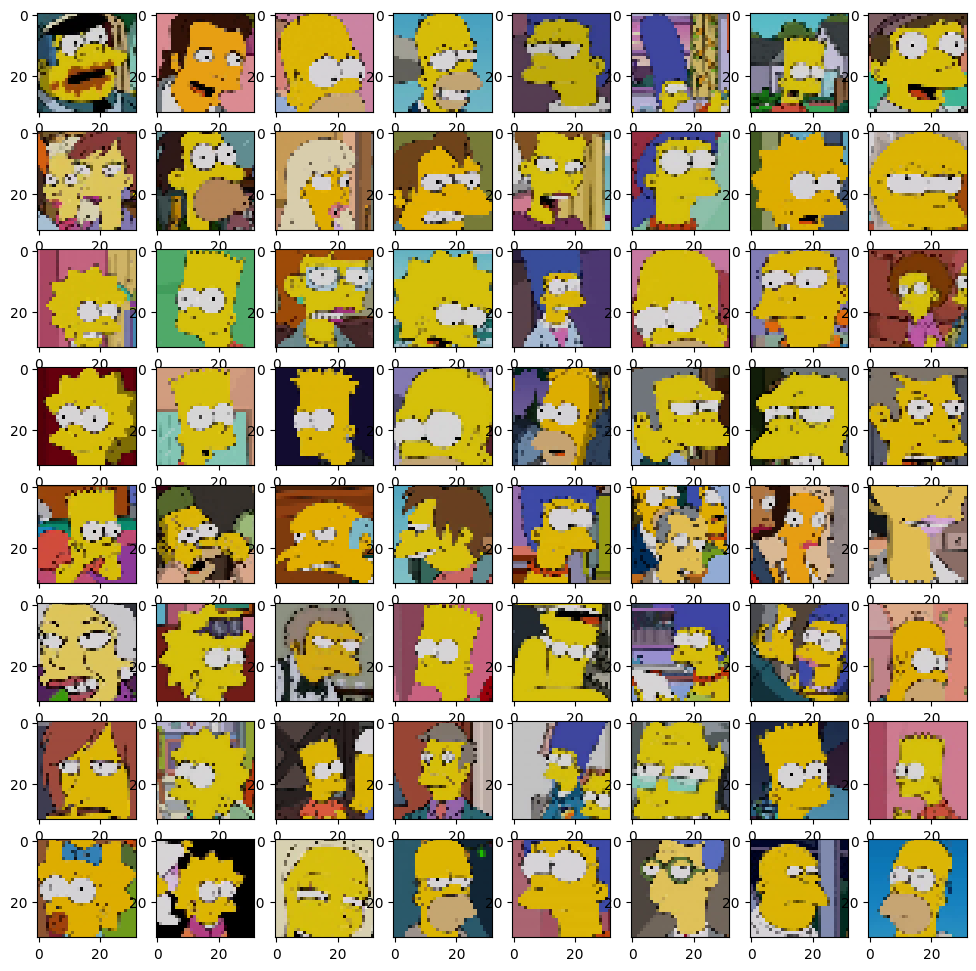

In [ ]:
# ADD CODE HERE
batch = next(iter(train_loader))
print(batch[0].shape)

# ADD CODE HERE
plt.figure(figsize=(12,12))
for i in range(64):
  plt.subplot(8,8, i+1)
  plt.imshow(dataset[i][:].permute(1,2,0))

### VAE class
#### Write a VAE class in the following cell

In [ ]:
# ADD CODE HERE
class VAE(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.nz = nz
    self.econv1 = nn.Conv2d(3, 16, 3, 1, 1)
    self.ebn1 = nn.BatchNorm2d(16)
    self.econv2 = nn.Conv2d(16, 32, 3, 2, 1)
    self.ebn2 = nn.BatchNorm2d(32)
    self.econv3 = nn.Conv2d(32, 64, 3, 2, 1)
    self.ebn3 = nn.BatchNorm2d(64)
    self.elinear1 = nn.Linear(64*8*8, 100)
    self.ebn4 = nn.BatchNorm1d(100)
    self.elinear2 = nn.Linear(100, self.nz)

    self.dlinear1 = nn.Linear(self.nz, 100)
    self.dbn1 = nn.BatchNorm1d(100)
    self.dlinear2 = nn.Linear(100, 64*8*8)
    self.dbn2 = nn.BatchNorm1d(64*8*8)
    self.dtconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding = 1)
    self.dbn3 = nn.BatchNorm2d(32)
    self.dtconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding = 1)
    self.dbn4 = nn.BatchNorm2d(16)
    self.dtconv3 = nn.ConvTranspose2d(16, 3, 3, 1, 1)


    self.plinear1 = nn.Linear(self.nz, self.nz)
    self.plinear2 = nn.Linear(self.nz, self.nz)


  def encoder_head(self, x):
    x = torch.relu(self.econv1(x))
    x = self.ebn1(x)

    x = torch.relu(self.econv2(x))
    x = self.ebn2(x)

    x = torch.relu(self.econv3(x))
    x = self.ebn3(x)

    x = x.view(-1,64*8*8)

    x = torch.relu(self.elinear1(x))
    x = self.ebn4(x)

    x = torch.sigmoid(self.elinear2(x))
    return x


  def get_params(self, x):
    mu = self.plinear1(x)
    logvar = self.plinear2(x)
    return mu, logvar

  def encoder(self, x):
    x = self.encoder_head(x)
    mu, logvar = self.get_params(x)
    z = torch.exp(0.5*logvar) * torch.randn_like(logvar) + mu
    return z, mu, logvar

  def decoder(self, x):
    x = torch.relu(self.dlinear1(x))
    x = self.dbn1(x)

    x = torch.relu(self.dlinear2(x))
    x = self.dbn2(x)

    x = x.view(-1, 64,8,8)

    x = torch.relu(self.dtconv1(x))
    x = self.dbn3(x)

    x = torch.relu(self.dtconv2(x))
    x = self.dbn4(x)

    x = torch.sigmoid(self.dtconv3(x))

    return x


  def forward(self, x):
    z, mu, logvar = self.encoder(x)
    x = self.decoder(z)
    return z, x, mu, logvar



## Loss
#### Define Loss function in the following cell

In [ ]:
# ADD CODE HERE
def get_loss(x, xhat, mu, logvar):
  m = 1e-4
  recon_loss = F.mse_loss(x,xhat)
  kld_loss = torch.mean(torch.sum(-0.5*(1+logvar - torch.exp(logvar)- mu**2), dim=1), dim=0)
  loss = m*kld_loss + (1-m)*recon_loss
  return loss


### Training Loop
#### Define optimizer, write the training loop in the following cell, and plot the loss

<ipython-input-12-f93bcbfaebd7>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im =  Image.imread(f"{self.image_path}{self.images[idx]}")


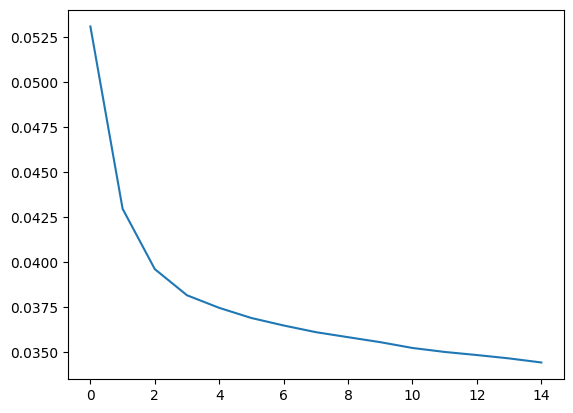

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Update the question marks '?' and add code where needed
nz = 64
net = VAE(nz).to(device)
num_epochs = 15
lr = 1e-2
opt = optim.Adam(net.parameters(), lr=lr)


ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    # ADD CODE HERE
    X = batch.to(device)
    Z, Xhat, mu, logvar = net(X)
    loss = get_loss(Xhat, X, mu, logvar)
    total_loss+= loss.item()
    opt.zero_grad()
    loss.backward()
    opt.step()

  ls.append(total_loss/len(train_loader))


plt.plot(ls)


## Generate and Plot Data
#### Generate a batch of 64 images and plot them in subplots of 8 rows and 8 columns.

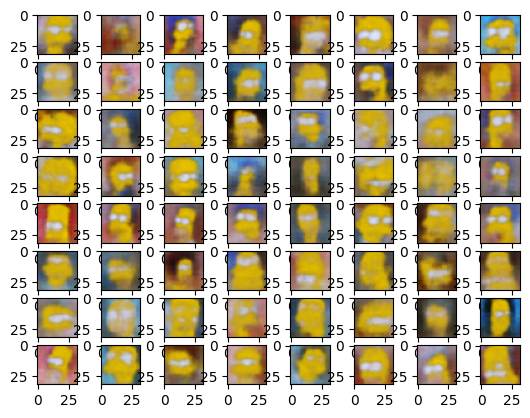

In [ ]:
# ADD CODE HERE
num_samples = 64
z = torch.randn((num_samples, 64)).to(device)
with torch.no_grad():
  Xhat = net.decoder(z)

for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(Xhat[i].cpu().permute(1,2,0))